In [154]:
#Importa as bibliotecas
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from imutils.contours import sort_contours
import imutils
from google.colab.patches import cv2_imshow

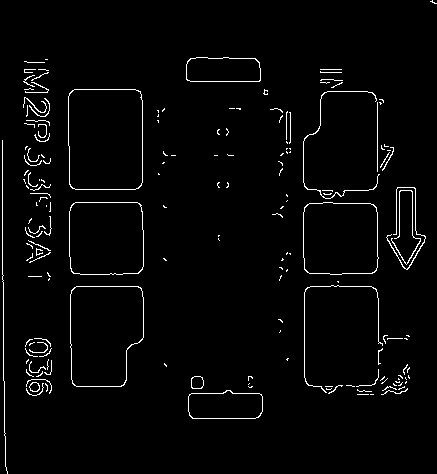

In [155]:
# Ler a imagem do pallete
img = cv2.imread('/content/pallete01.jpg')
#Converte a imagem para escala de cinza
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Aplica um filtro gaussiano para reduzir ruídos
desfoque = cv2.GaussianBlur(gray, (7,7), 0)
#Realiza a segmentação por bordas
canny = cv2.Canny(desfoque, 180, 210)
#Exibe a imagem
cv2_imshow(canny)

## Detecção dos contornos

In [156]:
#Define a função para encontrar os contornos
def encontrar_contornos(img):
  #Encontra os contornos
  conts = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  #Extrai os contornos da lista de contornos
  conts = imutils.grab_contours(conts)
  #Ordena os contornos
  conts = sort_contours(conts, method='left-to-right')[0]
  return conts

In [157]:
#Encontrar contornos na imagem segmentada por bordas.
conts = encontrar_contornos(canny.copy())

## Predição

In [158]:
#Carrega o modelo para reconhecer as setas
model = load_model('modelo_setas10.h5')

In [159]:
#Define a função para realizar a predição
def predicao(img):
  img = cv2.resize(img, (128, 128))  # Redimensione para o tamanho adequado para a entrada da rede neural
  img = img / 255.0  # Normaliza os valores dos pixels
  predictions = model.predict(np.expand_dims(img, axis=0))  # Realiza a predição
  predicted_class = np.argmax(predictions)   # Recupera o indice da maior probabiliade
  class_to_direction = {0: "Baixo", 1: "Esquerda", 2: "Direita", 3: "Cima"}  # Define os rótulos
  direction = class_to_direction[predicted_class]   # Obtém o valor do rótulo predito
  probabilidade = predictions[0][predicted_class]   # Obtem o valor da maior probabilidade
  return direction, probabilidade #retorna a direção e a maior probablididade

1/1 [==============================] - 0s 229ms/step


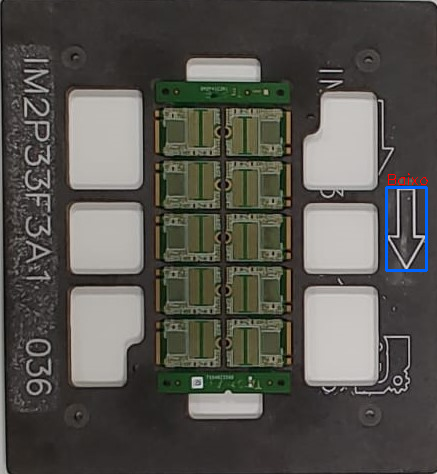

In [160]:
#Define parâmetros do filtro para a altura e largura dos contornos para eliminar contornos indesejados
l_min, l_max = 35, 85
a_min, a_max = 35, 85

#Copia a imagem original
img_cp = img.copy()
for c in conts:
  (x, y, w, h) = cv2.boundingRect(c) #Desmembra a variável contornos

  if (w >= l_min and w <= l_max) and (h >= a_min and h <= a_max):  #Esse if é para aplicar o filtro na altura e largura dos contornos
    roi = img_cp[y:y+ h, x:x + w] #Recorta apenas os contornos da imagem

    direcao, probabilidade = predicao(roi) #Realiza a predição

    if(probabilidade > 0.98): #Aplica um filtro nas probabilidades
      #Desenha um retângulo em volta das setas

      cv2.rectangle(img_cp, (x, y), (x + w, y + h), (255, 100, 0), 2)
      #Desenha um texto em volta das setas
      cv2.putText(img_cp, direcao, (x, y - 3), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
#Exibe a imagem
cv2_imshow(img_cp)